# Importing packages

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor 
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_validate, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Importing and cleaning the data

### Importing

In [2]:
total_df = pd.read_csv(r"C:\Users\titou\Desktop\python_test_files\ML_classic\hackathon\california_housing_hackathon\housing.csv")
total_df.sample(frac=1).reset_index(drop=True)
test_df = total_df.iloc[-2000:]
total_df = total_df.iloc[:-2000]

print(total_df.info(), "\n")
total_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18640 entries, 0 to 18639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           18640 non-null  float64
 1   latitude            18640 non-null  float64
 2   housing_median_age  18640 non-null  float64
 3   total_rooms         18640 non-null  float64
 4   total_bedrooms      18462 non-null  float64
 5   population          18640 non-null  float64
 6   households          18640 non-null  float64
 7   median_income       18640 non-null  float64
 8   median_house_value  18640 non-null  float64
 9   ocean_proximity     18640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.4+ MB
None 



,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### Plotting

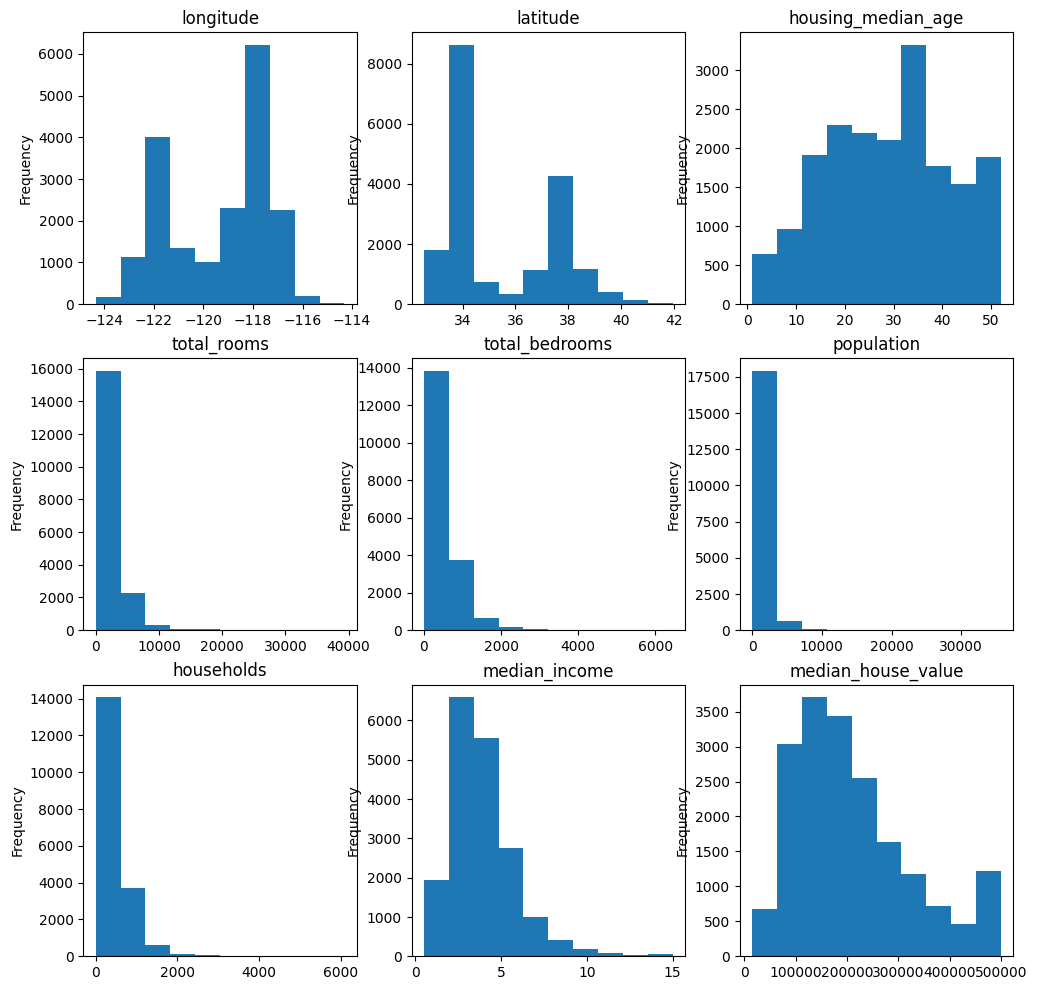

In [3]:
n = len(total_df.columns[:-1])
ncols = 3
nrows = (n + ncols - 1) // ncols  # auto number of rows

fig, axes = plt.subplots(nrows, ncols, figsize=(12, 4 * nrows))
axes = axes.flatten()

for i, col in enumerate(total_df.columns[:-1]):
    total_df[col].plot(kind="hist", ax=axes[i], title=col)

<Axes: xlabel='ocean_proximity'>

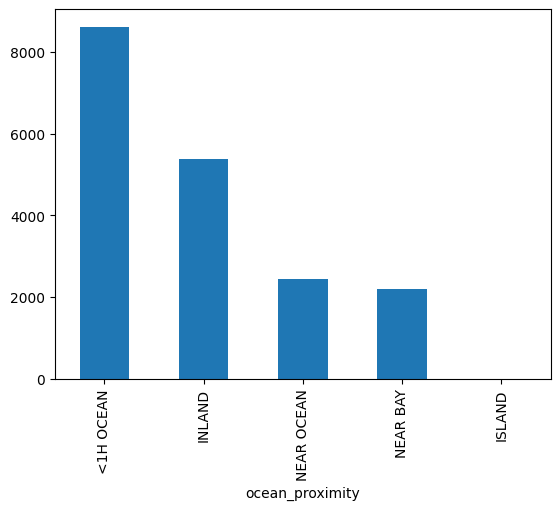

In [4]:
total_df["ocean_proximity"].value_counts().plot(kind="bar")

<Axes: >

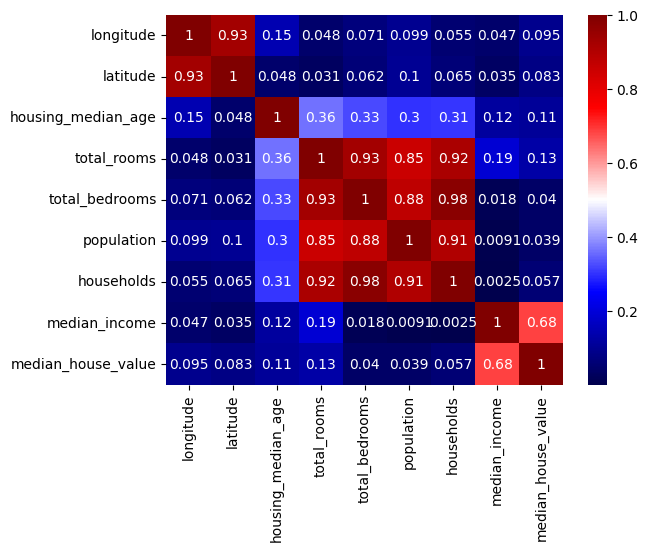

In [5]:
sns.heatmap(abs(total_df.iloc[:,:-1].corr()),annot=True, cmap="seismic")

### Refomrating

In [6]:
one_hot_encoded = pd.get_dummies(total_df["ocean_proximity"],dtype="int") 


total_df_refromated= total_df.drop(columns=["ocean_proximity"])
total_df_refromated = pd.concat([total_df_refromated, one_hot_encoded], axis=1)
total_df_refromated.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0,0,0,1,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0,0,0,1,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0,0,0,1,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0,0,0,1,0


In [7]:
def X_y_split(total_df_refromated):
    X_df = total_df_refromated.loc[:,total_df_refromated.columns != "median_house_value"]
    y_df = total_df_refromated.loc[:,["median_house_value"]] / 2e4
    return X_df, y_df

def fill_na(X_train_df, X_test_df):
    impute = SimpleImputer(strategy="median")
    X_train_df[["total_bedrooms"]] = impute.fit_transform(X_train_df[["total_bedrooms"]])
    X_test_df[["total_bedrooms"]] = impute.transform(X_test_df[["total_bedrooms"]])
    return X_train_df, X_test_df

def fill_na_linear(X_train_df, X_test_df):
    na_mask_train = X_train_df["total_bedrooms"].isna().values
    na_mask_test = X_test_df["total_bedrooms"].isna().values
    input_columns = ["total_rooms", "population", "households"]


    model_lr = LinearRegression()
    model_lr.fit(X_train_df.loc[~na_mask_train, input_columns], X_train_df.loc[~na_mask_train, "total_bedrooms"])

    X_train_df.loc[na_mask_train, "total_bedrooms"] = model_lr.predict(X_train_df.loc[na_mask_train, input_columns])
    X_test_df.loc[na_mask_test, "total_bedrooms"] = model_lr.predict(X_test_df.loc[na_mask_test, input_columns])
    return X_train_df, X_test_df

    # even better:
    # from sklearn.experimental import enable_iterative_imputer  # noqa
    # from sklearn.impute import IterativeImputer
    # from sklearn.linear_model import Ridge

    # imp = IterativeImputer(estimator=Ridge(alpha=1.0), random_state=42)
    # X_train_df[numeric_columns] = imp.fit_transform(X_train_df[numeric_columns])
    # X_test_df[numeric_columns]  = imp.transform(X_test_df[numeric_columns])


def standardize(X_train_df, X_test_df, numeric_variables):
    scaler = StandardScaler()
    X_train_df[numeric_variables] = scaler.fit_transform(X_train_df[numeric_variables])
    X_test_df[numeric_variables] = scaler.transform(X_test_df[numeric_variables])
    return X_train_df, X_test_df

In [8]:
numeric_variables = total_df_refromated.columns[:8]

X_df, y_df = X_y_split(total_df_refromated)
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, test_size=0.2, random_state=42)

X_train_df, X_test_df = fill_na_linear(X_train_df, X_test_df)
X_train_df, X_test_df = standardize(X_train_df, X_test_df, numeric_variables)

# Model Evaluation on a single instant

In [9]:
def plot_scatter_evaluation(y_test_df, y_predict_test):
    plt.scatter(y_test_df.values, y_predict_test, alpha=0.5)
    plt.xlabel("True price")
    plt.ylabel("Predicted Price")
    plt.plot([y_test_df.min(), y_test_df.max()],
            [y_test_df.min(), y_test_df.max()],
            'r--', label='Ideal fit')
    plt.legend()

### Linear regression

In [10]:
model_lr = LinearRegression()
model_lr.fit(X_train_df, y_train_df)
model_lr.predict(X_test_df)

array([[10.05064173],
       [13.36744784],
       [ 7.04743213],
       ...,
       [ 3.36447001],
       [ 9.6124007 ],
       [ 8.02086338]], shape=(3728, 1))

For linear regression, the MSE on the test set is : 12.712268474020181
The R score is 0.6242464706617374


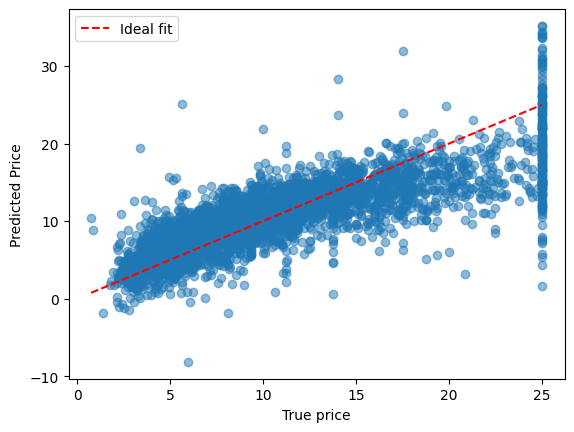

In [11]:
y_predict_test_lr = model_lr.predict(X_test_df)
print(f"For linear regression, the MSE on the test set is : {mean_squared_error(y_test_df.values, y_predict_test_lr)}")
print(f"The R score is {model_lr.score(X_test_df, y_test_df)}")
plot_scatter_evaluation(y_test_df, y_predict_test_lr)

### Random Forest

In [12]:
rf = RandomForestRegressor(n_estimators=100, min_samples_split=2, min_samples_leaf=1)
rf.fit(X_train_df, y_train_df)
rf.predict(X_test_df)

c:\Users\titou\Desktop\python_test_files\virtual_environments\ml_env\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


array([10.1113 ,  9.81045,  7.2047 , ...,  3.7853 ,  7.0808 ,  7.94245],
      shape=(3728,))

For Random Forest, the MSE on the test set is : 6.19e+00


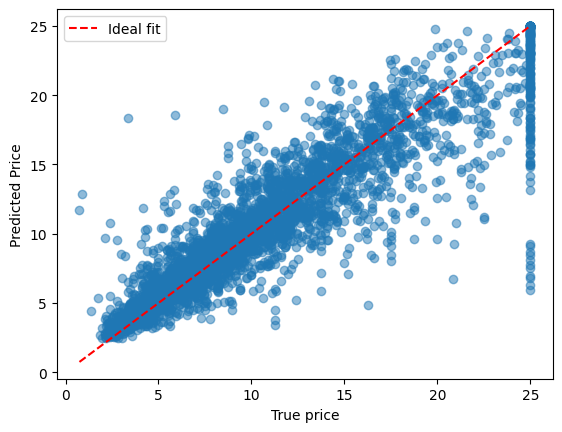

In [13]:
y_predict_test_rf = rf.predict(X_test_df)
print(f"For Random Forest, the MSE on the test set is : {mean_squared_error(y_test_df.values, y_predict_test_rf):.2e}")
plot_scatter_evaluation(y_test_df, y_predict_test_rf)

### XGBoost

In [21]:
xgb_model = XGBRegressor()
xgb_model.fit(X_train_df.values, y_train_df)
xgb_model.predict(X_test_df)

array([10.770706 , 11.9380865,  5.8077416, ...,  3.0624063,  6.6466193,
        8.5217905], shape=(3728,), dtype=float32)

For XGboost, the MSE on the test set is : 5.97e+00


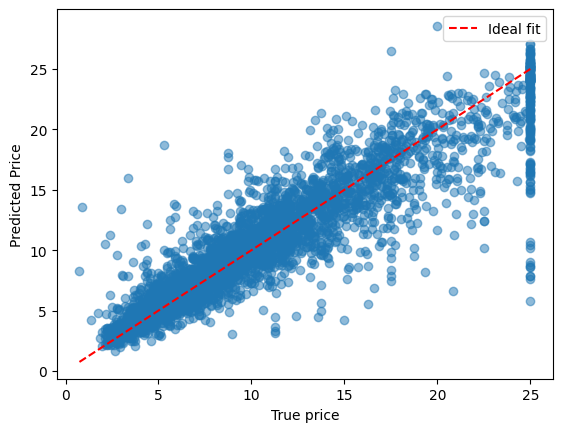

In [22]:
y_predict_test_xgb = xgb_model.predict(X_test_df.values)
print(f"For XGboost, the MSE on the test set is : {mean_squared_error(y_test_df.values, y_predict_test_xgb):.2e}")
plot_scatter_evaluation(y_test_df, y_predict_test_xgb)

### Neural Network

In [23]:
X_train_df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype='object')

# Model selection with cross-validation

### Implementation without pipeline (massive bias due to standardization and bias)

In [18]:
X_df, y_df = X_y_split(total_df_refromated)

X_df, _ = fill_na_linear(X_df, X_df.copy())
X_df, _ = standardize(X_df, X_df.copy(), numeric_variables)

C:\Users\titou\AppData\Local\Temp\ipykernel_16048\3809367934.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_df[numeric_variables] = scaler.fit_transform(X_train_df[numeric_variables])


In [50]:
xgb_model = XGBRegressor()
cv = KFold(n_splits=10, shuffle=True)
scores = cross_validate(xgb_model, X_df.values, y_df.values,scoring=["neg_mean_squared_error", "r2"], cv=cv)

In [51]:
print(f"MSE error: {scores["test_neg_mean_squared_error"].mean()}")
print(f"r2 error: {scores["test_r2"].mean()}")
#, scoring="neg_mean_squared_error"

MSE error: -5.660400343455671
r2 error: 0.8334473567696591


# Model selection with grid seach

### Implementation without pipeline (massive bias due to standardization and bias)

In [79]:
xgb_model = XGBRegressor(eta=0.3, gamma=0.1, reg_lambda=0.2, max_depth = 5, min_child_weight=1)

parameter_grid = {"eta": [0.1,0.3], "gamma": [0.1, 0.3], "reg_lambda": [0.1, 0.3], "max_depth": [5,10], "min_child_weight": [1, 3]}
cv_Kfold = KFold(5, shuffle=True)
xgb_cv = GridSearchCV(xgb_model, parameter_grid, scoring="neg_mean_squared_error", cv=cv_Kfold)
xgb_cv.fit(X_df.values, y_df.values)

print("Best parameters:", xgb_cv.best_params_)
print("Mean CV MSE:", -xgb_cv.best_score_)


Best parameters: {'eta': 0.1, 'gamma': 0.3, 'max_depth': 10, 'min_child_weight': 3, 'reg_lambda': 0.1}
Mean CV MSE: 5.657517944873851
